# Variational Sparse Gaussian Process Classification (白色化なし)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

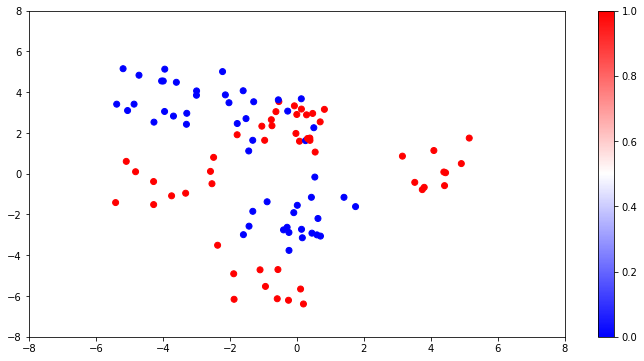

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = False)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % (n_epochs / 10) == 0:
        print(loss)

173.0404154116796
67.38919371493674
63.61873481865214
53.30622369583699
51.08345980645876
46.383485245005716
52.42806571367183
48.05674118024293
48.064744885023515
53.37330791666069


---

## 推論結果

### 予測分布

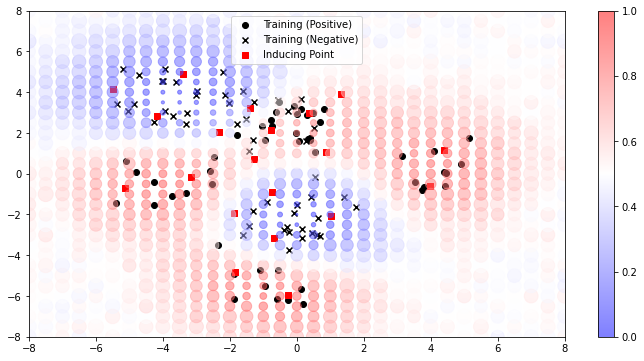

CPU times: user 21.2 s, sys: 781 ms, total: 22 s
Wall time: 5.98 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.5954, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-0.7830,  2.1359],
        [-5.4763,  4.1673],
        [ 4.4104,  1.1519],
        [-1.2843,  0.7234],
        [-3.1599, -0.1719],
        [-4.1745,  2.8149],
        [-1.8590, -4.8077],
        [-0.7448, -0.9125],
        [ 0.3591,  2.9679],
        [-1.8827, -1.9183],
        [ 1.3098,  3.8938],
        [-3.3853,  4.9022],
        [ 3.9878, -0.5860],
        [-1.3905,  3.2005],
        [-5.1349, -0.7022],
        [-2.3338,  2.0286],
        [-0.2515, -5.9382],
        [ 1.0238, -2.0912],
        [ 0.8868,  1.0463],
        [-0.6746, -3.1324]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.6561, -1.4304,  1.4005,  0.4001,  1.4006, -1.6604,  1.0491, -1.2732,
          1.0212, -0.5448,  0.6151, -2.0628,  1.3109, -0.6365,  1.2574, -0.4690,
          1.5742, -1.9519,  0.7848, -1.3904]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 2.4876e-01, -2.0872e-02, -4.1672e-02,  1.4993e-01, -7.2136e-04,
           1.6460e-02,  7.9811e-03,  4.5786e-02,  8.7988e-02, -1.3691e-02,
          -3.8955e-02, -2.7935e-03, -1.5748e-02,  1.2517e-01, -1.1944e-02,
           1.0725e-01,  1.6861e-02,  1.8810e-02,  5.4139e-02,  6.0921e-02],
         [-2.0872e-02,  8.1212e-01,  4.7030e-03, -8.6928e-02, -3.8373e-03,
           1.9445e-01, -7.6752e-02,  3.8627e-02,  8.2812e-03,  6.8285e-04,
          -1.8645e-02,  1.7022e-01, -5.3705e-02, -1.8035e-02, -6.1732e-02,
          -2.4186e-02, -1.0195e-01, -1.3604e-01,  1.2430e-02, -4.3355e-02],
         [-4.1672e-02,  4.7030e-03,  5.4704e-01,  6.4857e-02, -5.1302e-02,
           3.6433e-02, -2.3041e-02,  1.9439e-02, -2.9302e-04, -1.0675e-03,
           6.7536e-02, -3.4585e-02,  2.2550e-01, -5.9184e-02,  5.5561e-04,
          -2.6241e-02,  2.7396e-02,  4.3039e-02, -8.3091e-02,  2.9982e-02],
         [ 1.4993e-01, -8.6928e-02,  6.4857e-02,  4.9152e-01,  9.7665e-02,
          -4.1700e-02,